In [189]:
from hcipy import *

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import time
import os

from progressbar import progressbar
from FFMpegWriter import FFMpegWriter
from matplotlib.patches import Rectangle

%matplotlib inline


In [190]:
telescope_diameter = 2.4 # meter
central_obscuration = 0.4 # meter
central_obscuration_ratio = central_obscuration / telescope_diameter
spider_width = 0.01 # meter

# oversizing_factor = 16 / 15
num_pupil_pixels = 240
pupil_grid_diameter = telescope_diameter #* oversizing_factor
#why oversize? prevent aliasing, think of it as "padding" the edges
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

aperture_generator = make_obstructed_circular_aperture(telescope_diameter,
    central_obscuration_ratio, num_spiders=4, spider_width=spider_width)

aperture = evaluate_supersampled(aperture_generator, pupil_grid, 4)
# renders the aperture at 4x resolution before downsampling to prevent aliasing


wavelength_wfs = 0.632e-6
wavelength_sci = 0.6e-6 # scientific camera wavelength
#PMH - changed to NIR (2.2 um) for demo purposes.
# wavelength_sci = 2.2e-6 # scientific camera wavelength

wf = Wavefront(aperture, wavelength_sci)
wf.total_power = 1

# scientific camera
spatial_resolution = wavelength_sci / telescope_diameter #arcsec
focal_grid = make_focal_grid(q=4, num_airy=30, spatial_resolution=spatial_resolution)
# q=4 means 4 pixels per spatial resolution element (lambda/D)

# --- spectroscopy slit mask (rectangular, 0.5") --------------------------
arcsec2rad   = np.pi / (180.0 * 3600.0)
slit_width   = 0.5 * arcsec2rad        # 0.5 arcsec → rad
slit_mask    = (np.abs(focal_grid.x) <= slit_width/2)   # slit is tall, narrow in x


# -----------------------------

# storage for diagnostics

propagator = FraunhoferPropagator(pupil_grid, focal_grid)


0.003072


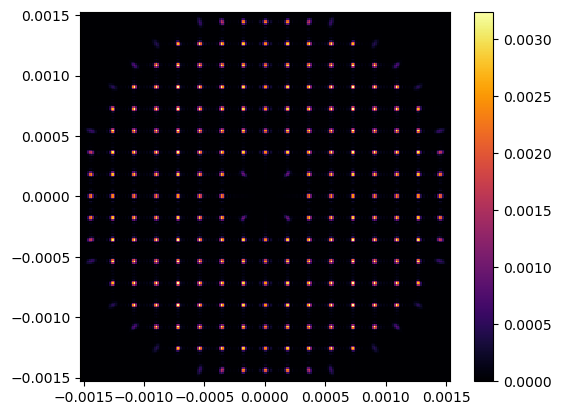

In [191]:
f_number = 5.2/.146 #focal length/lenslet lens size using Thorlabs MLA150-5C-M - Ø1" Mounted Lens Array
f_number = 50 # PMH- guess. Alpao doesn't provide documentation.

num_lenslets = 17 # 15 lenslets along one diameter
sh_diameter = 16* 1.92E-4   #PMH - Alpao EMCCD has 192 um lenslets
print (sh_diameter)
magnification = sh_diameter / telescope_diameter
magnifier = Magnifier(magnification)

shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number, \
                                                 num_lenslets, sh_diameter)
shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)



camera = NoiselessDetector(focal_grid)
wf = Wavefront(aperture, wavelength_wfs)
camera.integrate(shwfs(magnifier(wf)), 1)

image_ref = camera.read_out()

imshow_field(image_ref, cmap='inferno')
plt.colorbar()
plt.show()


try an 8x8 subaperture shack hartman, then go up to 12x12 and down to 4x4 (probably can only correct 10 modes).

In [192]:
from SamDeformableMirror import make_gaussian_influence_functions, SamDeformableMirror

influence_functions = make_gaussian_influence_functions(pupil_grid, num_rings=5,
                                                        crosstalk=0.3,
                                                        points_first_ring=6, actuator_spacing=0.3)

# influence_functions = make_gaussian_influence_functions(pupil_grid, triangle_layout=True,
                                                        # circular_layout=False, num_rings=5,
                                                        # points_first_ring=6, crosstalk=0.3,
                                                        # actuator_spacing=0.3)


deformable_mirror = SamDeformableMirror(influence_functions)
print (len(deformable_mirror.actuators))

91


/opt/homebrew/anaconda3/envs/hcipy_env/lib/python3.10/site-packages/hcipy/field/grid.py:107: UserWarning: No automatic weights could be calculated for this grid.
  if np.isscalar(self.weights):


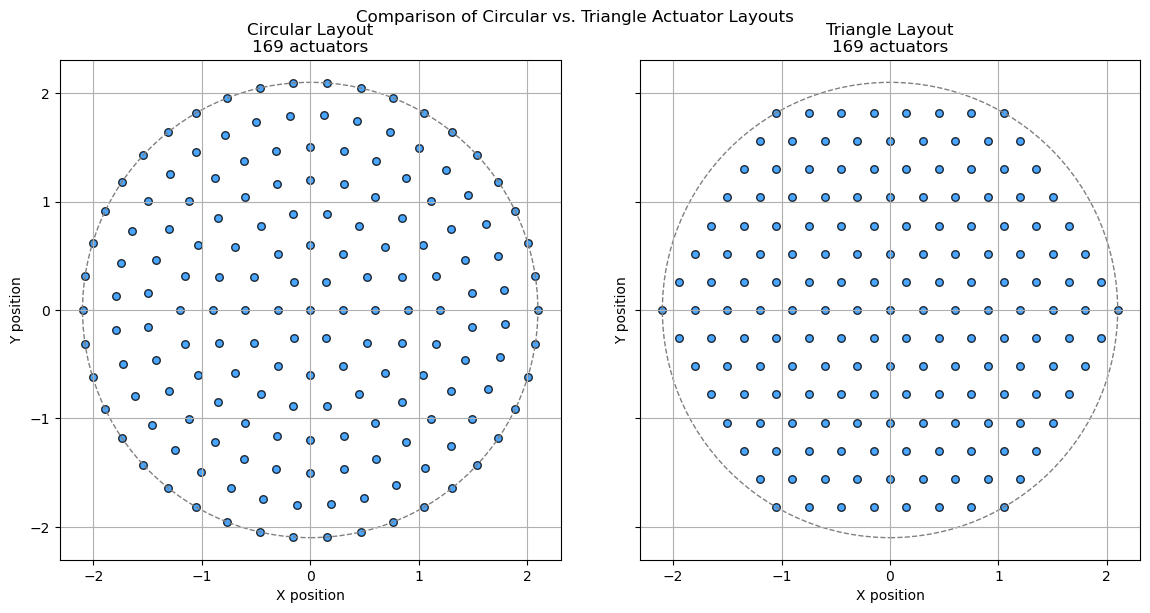

In [193]:
import numpy as np
import matplotlib.pyplot as plt

def plot_actuator_layouts(points1, points2, radius, labels=('Circular', 'Triangle')):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    for ax, points, label in zip(axs, [points1, points2], labels):
        x, y = points[:, 0], points[:, 1]
        ax.scatter(x, y, s=30, color='dodgerblue', edgecolor='k', alpha=0.8)
        circle = plt.Circle((0, 0), radius, color='gray', fill=False, linestyle='--')
        ax.add_artist(circle)
        ax.set_aspect('equal')
        ax.set_title(f'{label} Layout\n{len(points)} actuators')
        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')
        ax.grid(True)

    plt.suptitle('Comparison of Circular vs. Triangle Actuator Layouts')
    plt.tight_layout()
    plt.show()

def dummy_circular_actuators(num_rings, points_first_ring, spacing, oversampling=1):
    points = [(0.0, 0.0)]
    for ring in range(1, num_rings + 1):
        r = ring * spacing
        # n = ring * points_first_ring
        n = int(np.ceil(ring * points_first_ring * oversampling))
        offset = (np.pi / (ring - 1) * points_first_ring) if ring > 1 else 0
        for i in range(n):
            theta = offset + 2 * np.pi * i / n
            points.append((r * np.cos(theta), r * np.sin(theta)))
    return np.array(points)


def dummy_triangular_actuators(num_rings, spacing):
    v1 = np.array([spacing, 0.0])
    v2 = np.array([spacing / 2, spacing * np.sqrt(3) / 2])
    points = [(0.0, 0.0)]
    for k in range(1, num_rings + 1):
        for i in range(-k, k + 1):
            for j in range(-k, k + 1):
                if max(abs(i), abs(j), abs(-i - j)) == k:
                    pos = i * v1 + j * v2
                    points.append((pos[0], pos[1]))
    return np.array(points)

# Parameters
num_rings = 7
points_first_ring = 6
spacing = 0.3
max_radius = num_rings * spacing

# Generate both layouts
circ_pts = dummy_circular_actuators(num_rings, points_first_ring, spacing, oversampling=1)
tri_pts = dummy_triangular_actuators(num_rings, spacing)

# Apply circular mask
margin = spacing / 2
circ_pts = circ_pts[np.linalg.norm(circ_pts, axis=1) <= (max_radius+margin)]
tri_pts = tri_pts[np.linalg.norm(tri_pts, axis=1) <= max_radius]

# Plot
plot_actuator_layouts(circ_pts, tri_pts, radius=max_radius)


In [194]:
# num_actuators = deformable_mirror.num_actuators
# poke_amp = 1  # poke amplitude in meters
# pokevec = []
# for a in range (num_actuators) :
#     amp = np.zeros((num_actuators,))
#     amp[a] = poke_amp
#     deformable_mirror.actuators = amp
#     wavefront = deformable_mirror.surface * aperture / 2.0
#     pokevec=np.concatenate((pokevec,wavefront),axis=0)          #Create vector first
# (numpix,) = np.shape(wavefront)
# pokecube = np.reshape(pokevec,(num_actuators,numpix)).T              #reshape to matrix.
# deformable_mirror.flatten()

# zernike_basis = make_zernike_basis(num_modes+1, pupil_grid_diameter, pupil_grid)

# pc = pokecube
# pcT =pc.T
# pcTxpc = np.dot(pcT, pc )
# Transform = np.linalg.solve(pcTxpc, pcT)
# actvec = []
# for zz in range (1,num_modes+1) :      #Ignore piston
#     act = np.dot (Transform,zernike_basis[zz])
#     # print ("act:",np.shape(act))
#     actvec = np.concatenate((actvec,act),axis = 0)
#     # print ("actvec", np.shape(actvec))
# Mode2Act = np.reshape(actvec,(num_modes,num_actuators)).T

# #defocus_actuators = Mode2Act[:, 1]
# defocus_actuators = Mode2Act[:, 2]    #PMH- defocus is mode #2

# deformable_mirror.actuators = defocus_actuators




In [195]:
# for j in range(1, num_modes+1):  # skip piston (j=0)
#     # find actuator weights that reproduce Zernike j
#     a_j = np.dot(Transform,zernike_basis[j])
#     Mode2Act[:, j-1] = a_j

# # Loop over Zernike modes to build the interaction (response) matrix
# probe_amp = 0.01 * wavelength_wfs
# response_matrix = []

# # set up animation writer
# plt.figure(figsize=(10, 6))
# anim = FFMpegWriter('response_matrix_zernike.mp4', framerate=5)

# # excite each Zernike mode with ±probe_amp
# for m in progressbar(range(num_modes)):
#     slope = 0

#     # get the unit actuator shape for Zernike m
#     mode_act = Mode2Act[:, m]

#     for sign in (-1, +1):
#         deformable_mirror.flatten()
#         deformable_mirror.actuators = sign * probe_amp * mode_act

#         # propagate and sense
#         dm_wf  = deformable_mirror.forward(wf)
#         wfs_wf = shwfs(magnifier(dm_wf))
#         camera.integrate(wfs_wf, 1)
#         image = camera.read_out()

#         slopes = shwfse.estimate([image])
#     # ------------------------------------------------ THIS WAS THE PROBLEM
#         if sign == -1:
#             s_minus = slopes
#         else:
#             s_plus  = slopes

#         # slope += sign * slopes / np.var([-probe_amp, +probe_amp]) #i thought this was delta**2 but it was supposed to be delta*2

#     slope = (s_plus - s_minus) / (2 * probe_amp)
#     # ------------------------------------------------ THIS WAS THE PROBLEM (END)
#     response_matrix.append(slope.ravel())

#     # only animate the first 40 modes, then every 20th thereafter
#     if m <= 40 or (m+1) % 20 == 0:
#         plt.clf()
#         plt.suptitle(f'Zernike Mode {m+1}/{num_modes}')

#         # DM surface
#         plt.subplot(1,2,1)
#         plt.title('DM Surface')
#         im1 = imshow_field(deformable_mirror.surface, cmap='RdBu', mask=aperture)
#         plt.colorbar()

#         # SH spots + quiver
#         plt.subplot(1,2,2)
#         plt.title('SH Spots & Slopes')
#         im2 = imshow_field(image)
#         quiv = plt.quiver(
#             shwfs.mla_grid.subset(shwfse.estimation_subapertures).x,
#             shwfs.mla_grid.subset(shwfse.estimation_subapertures).y,
#             slope[0,:], slope[1,:],
#             color='white'
#         )

#         anim.add_frame()

# # finalize
# response_matrix = ModeBasis(response_matrix)
# plt.close()
# anim.close()


# rcond = 1e-3


# reconstruction_matrix = inverse_tikhonov(response_matrix.transformation_matrix, rcond=rcond)
# print(reconstruction_matrix.shape)
# anim

In [196]:

def compute_Mode2Act_and_reconstruction_matrix(num_modes, rcond=1e-3, animate=False, **kwargs):
    """
    Compute Mode2Act and reconstruction matrix from provided components.
    
    Parameters
    ----------
    num_modes : int
        Number of Zernike modes to project.
    rcond : float
        Tikhonov regularization parameter.
    animate : bool
        Whether to generate and save animation.
    **kwargs : dict
        Additional parameters required for computation, including:

        deformable_mirror : DeformableMirror
        Deformable mirror object.

        shwfs : ShackHartmannWavefrontSensor
            Shack-Hartmann WFS model.
        
        shwfse : ShackHartmannWavefrontSensorEstimator
            SHWFS estimator object for slope computation.

        camera : Camera
            WFS camera object.

        magnifier : OpticalElement
            Element to magnify the pupil onto the WFS.

        wf : Wavefront
            The wavefront object used for probing DM slopes.
    
        aperture : Field
            Aperture mask.

        pupil_grid : Grid
            The pupil grid.
        
        wavelength_wfs : float
            Wavelength for wavefront sensing (in meters).

            Diameter of the pupil (default is 1.0).

    Required keys in kwargs:
        deformable_mirror, shwfs, shwfse, camera, magnifier, wf,
        aperture, pupil_grid, wavelength_wfs, pupil_grid_diameter
    """
    deformable_mirror = kwargs["deformable_mirror"]
    shwfs = kwargs["shwfs"]
    shwfse = kwargs["shwfse"]
    camera = kwargs["camera"]
    magnifier = kwargs["magnifier"]
    wf = kwargs["wf"]
    aperture = kwargs["aperture"]
    pupil_grid = kwargs["pupil_grid"]
    wavelength_wfs = kwargs["wavelength_wfs"]
    pupil_grid_diameter = kwargs["pupil_grid_diameter"]

    num_actuators = deformable_mirror.num_actuators
    poke_amp = 1.0  # meter

    # Step 1: Poke matrix construction
    pokevec = []
    for a in range(num_actuators):
        amps = np.zeros((num_actuators,))
        amps[a] = poke_amp
        deformable_mirror.actuators = amps
        wavefront = deformable_mirror.surface * aperture / 2.0
        pokevec.append(wavefront)

    pokecube = np.array(pokevec).T  # (numpix, num_actuators)
    deformable_mirror.flatten()

    # Step 2: Zernike projection
    zernike_basis = make_zernike_basis(num_modes + 1, pupil_grid_diameter, pupil_grid)
    pcT = pokecube.T
    Transform = np.linalg.solve(np.dot(pcT, pokecube), pcT)

    Mode2Act = np.zeros((num_actuators, num_modes))
    for j in range(1, num_modes + 1):  # skip piston (j=0)
        a_j = np.dot(Transform, zernike_basis[j])
        Mode2Act[:, j - 1] = a_j

    # Step 3: Build interaction matrix (response to Zernike modes)
    probe_amp = 0.01 * wavelength_wfs
    response_matrix = []

    if animate:
        plt.figure(figsize=(10, 6))
        anim = FFMpegWriter('response_matrix_zernike_results.mp4', framerate=5)

    for m in progressbar(range(num_modes)):
        mode_act = Mode2Act[:, m]

        for sign in (-1, +1):
            deformable_mirror.flatten()
            deformable_mirror.actuators = sign * probe_amp * mode_act

            dm_wf = deformable_mirror.forward(wf)
            wfs_wf = shwfs(magnifier(dm_wf))
            camera.integrate(wfs_wf, 1)
            image = camera.read_out()

            slopes = shwfse.estimate([image])

            if sign == -1:
                s_minus = slopes
            else:
                s_plus = slopes

        slope = (s_plus - s_minus) / (2 * probe_amp)
        response_matrix.append(slope.ravel())

        if animate and (m <= 40 or (m + 1) % 20 == 0):
            plt.clf()
            plt.suptitle(f'Zernike Mode {m+1}/{num_modes}')

            # DM surface
            plt.subplot(1,2,1)
            plt.title('DM Surface')
            im1 = imshow_field(deformable_mirror.surface, cmap='RdBu', mask=aperture, vmax=3e-8, vmin=0)
            plt.colorbar()

            # SH spots + quiver
            plt.subplot(1,2,2)
            plt.title('SH Spots & Slopes')
            im2 = imshow_field(image)
            quiv = plt.quiver(
                shwfs.mla_grid.subset(shwfse.estimation_subapertures).x,
                shwfs.mla_grid.subset(shwfse.estimation_subapertures).y,
                slope[0,:], slope[1,:],
                color='white'
            )


            anim.add_frame()
    response_matrix = ModeBasis(response_matrix)
    reconstruction_matrix = inverse_tikhonov(response_matrix.transformation_matrix, rcond=rcond)
    if animate:
        plt.close()
        anim.close()
        return Mode2Act, reconstruction_matrix, anim
    else:

        return Mode2Act, reconstruction_matrix


    # Step 4: Finalize
    

In [197]:
shared_optics = {
    "deformable_mirror": deformable_mirror,
    "shwfs": shwfs,
    "shwfse": shwfse,
    "camera": camera,
    "magnifier": magnifier,
    "wf": wf,
    "aperture": aperture,
    "pupil_grid": pupil_grid,
    "wavelength_wfs": wavelength_wfs,
    "pupil_grid_diameter": pupil_grid_diameter
}
Mode2Act, reconstruction_matrix, anim = compute_Mode2Act_and_reconstruction_matrix(20, animate=True, **shared_optics)
anim

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/homebrew/anaconda3/envs/hcipy_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16

[############################################################] 20/20


Input #0, image2pipe, from 'fd:':
  Duration: N/A, bitrate: N/A
  Stream #0:0: Video: png, rgba(pc, gbr/unknown/unknown), 1000x600 [SAR 3937:3937 DAR 5:3], 5 fps, 5 tbr, 5 tbn
[out#0/mp4 @ 0x134f057d0] Codec AVOption crf (Select the quality for constant quality mode) has not been used for any stream. The most likely reason is either wrong type (e.g. a video option with no video streams) or that it is a private option of some encoder which was not actually used for any stream.
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libopenh264))
[libopenh264 @ 0x134f06790] [OpenH264] this = 0x0x107104e40, Warning:layerId(0) doesn't support profile(578), change to UNSPECIFIC profile
[libopenh264 @ 0x134f06790] [OpenH264] this = 0x0x107104e40, Warning:bEnableFrameSkip = 0,bitrate can't be controlled for RC_QUALITY_MODE,RC_BITRATE_MODE and RC_TIMESTAMP_MODE without enabling skip frame.
[libopenh264 @ 0x134f06790] [OpenH264] this = 0x0x107104e40, Warning:Change QP Range from(0,51) to (

# Without atmosphere (skip usually)

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/homebrew/anaconda3/envs/hcipy_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16

[############################################################] 20/20
[############################################################] 100/100


Input #0, image2pipe, from 'fd:':
  Duration: N/A, bitrate: N/A
  Stream #0:0: Video: png, rgba(pc, gbr/unknown/unknown), 800x800 [SAR 3937:3937 DAR 1:1], 10 fps, 10 tbr, 10 tbn
[out#0/mp4 @ 0x10b504880] Codec AVOption crf (Select the quality for constant quality mode) has not been used for any stream. The most likely reason is either wrong type (e.g. a video option with no video streams) or that it is a private option of some encoder which was not actually used for any stream.
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libopenh264))
[libopenh264 @ 0x10b5059a0] [OpenH264] this = 0x0x126618410, Warning:layerId(0) doesn't support profile(578), change to UNSPECIFIC profile
[libopenh264 @ 0x10b5059a0] [OpenH264] this = 0x0x126618410, Warning:bEnableFrameSkip = 0,bitrate can't be controlled for RC_QUALITY_MODE,RC_BITRATE_MODE and RC_TIMESTAMP_MODE without enabling skip frame.
[libopenh264 @ 0x10b5059a0] [OpenH264] this = 0x0x126618410, Warning:Change QP Range from(0,51) to

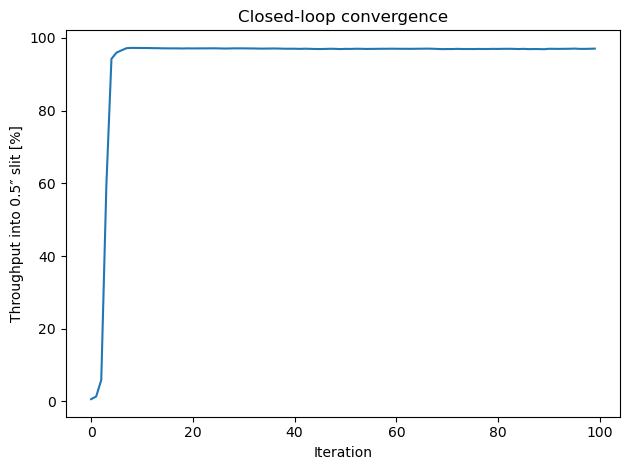

In [198]:
shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number, \
                                                 17, sh_diameter)
shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)


# Put actuators at random values, putting a little more power in low-order positions
n_act = deformable_mirror.num_actuators
np.random.seed(323)        #PMH - exact same random pattern each time
deformable_mirror.actuators =  np.random.randn(n_act) / (np.arange(n_act) + 10)

# Normalize the DM surface so that we get a reasonable surface RMS.
deformable_mirror.actuators *= 0.3 * wavelength_sci / np.std(deformable_mirror.surface)
deformable_mirror.actuators *= 0.1 * wavelength_sci / np.std(deformable_mirror.surface)   #reduce to get within range of SH

zero_magnitude_flux = 3.9e10 #3.9e10 photon/s for a mag 0 star
delta_t = 1e-3 # sec, so a loop speed of 1kHz.
# flux_for_mag = lambda mag: 100**(-0.2 * (mag)) # simplified Pogson relation
flux_for_mag = lambda mag :zero_magnitude_flux * 10**(-mag / 2.5)
guide_star_mag = 10.0
guide_star_mag = 0.0    #PMH - extremely bright star

star_flux = flux_for_mag(guide_star_mag)

wf_wfs = Wavefront(aperture, wavelength_wfs)
wf_wfs.total_power = star_flux
wf_sci = Wavefront(aperture, wavelength_sci)
wf_sci.total_power = star_flux


gain = 0.3

# gain is the proportion of the DM response that is applied to the DM actuators
leakage = 0.0000  #PMH reduced to confirm this is what is "correcting" the sequence
# leakage is the proportion of the DM response that leaks into the science camera
#PMH - the leakage is the fraction of the DM response that his removed from the correction each frame
#PMH - this is why the no turbulence model _appeared_ to correct the error. It was slowly regressing to its uncorrected shape
num_iterations = 100
throughput_vec = np.zeros(num_iterations)   # slit energy / total

long_exposure = 0
# print (zero_magnitude_flux * 10**(-guide_star_mag / 2.5))
# print (star_flux)

slopes_ref = shwfse.estimate([image_ref])

#PMH - create reference PSF
wf_sci_ideal = propagator(wf_sci)

Strehl_vec = np.zeros(num_iterations)

# Set up animation
plt.figure(figsize=(8, 8))
anim = FFMpegWriter('AO_simulation_without_turbulence.mp4', framerate=10)

y_span = focal_grid.y.max()

shared_optics = {
    "deformable_mirror": deformable_mirror,
    "shwfs": shwfs,
    "shwfse": shwfse,
    "camera": camera,
    "magnifier": magnifier,
    "wf": wf,
    "aperture": aperture,
    "pupil_grid": pupil_grid,
    "wavelength_wfs": wavelength_wfs,
    "pupil_grid_diameter": pupil_grid_diameter
}
Mode2Act, reconstruction_matrix = compute_Mode2Act_and_reconstruction_matrix(20, **shared_optics)

for timestep in progressbar(range(num_iterations)):
    wf_wfs = Wavefront(aperture, wavelength_wfs)
    wf_wfs.total_power = star_flux
    wf_sci = Wavefront(aperture, wavelength_sci)
    wf_sci.total_power = star_flux

    scale = 1.0 * 1

    vibfreq = 0.3
    vibamp = 5 * scale    #units?? 

    vibfreq2 = 0.03
    vibamp2 = 14.0 * scale

    vibfreq3 = 0.01
    vibamp3 = 10.0 * scale

    vibfreq4 = 1.3
    vibamp4 = 20.0 * scale

    vibphase =  vibfreq * 2 * np.pi * timestep * delta_t
    vibphase2 = vibfreq2 * 2 * np.pi * (timestep * delta_t + 0.3)
    vibphase3 = vibfreq3 * 2 * np.pi * (timestep * delta_t + 0.6)
    vibphase4 = vibfreq4 * 2 * np.pi * (timestep * delta_t + 0.9)

    # Apply vibration to wf_wfs_after_atmos
    wf_wfs.electric_field *= np.exp(1j * vibamp  * zb[1] * np.sin(vibphase))
    wf_wfs.electric_field *= np.exp(1j * vibamp2 * zb[1] * np.sin(vibphase2))
    wf_wfs.electric_field *= np.exp(1j * vibamp3 * zb[1] * np.sin(vibphase3))
    wf_wfs.electric_field *= np.exp(1j * vibamp4 * zb[1] * np.sin(vibphase4))
    wf_sci.electric_field *= np.exp(1j * vibamp  * zb[1] * np.sin(vibphase))
    wf_sci.electric_field *= np.exp(1j * vibamp2 * zb[1] * np.sin(vibphase2))
    wf_sci.electric_field *= np.exp(1j * vibamp3 * zb[1] * np.sin(vibphase3))
    wf_sci.electric_field *= np.exp(1j * vibamp4 * zb[1] * np.sin(vibphase4))


    # Propagate through SH-WFS
    wf_after_sh = shwfs(magnifier(deformable_mirror(wf_wfs)))

    # Propagate the NIR wavefront
    wf_sci_after_dm = propagator(deformable_mirror(wf_sci))

    # Read out WFS camera
    camera.integrate(wf_after_sh, delta_t)
    wfs_image = camera.read_out()
    wfs_image = large_poisson(wfs_image).astype('float')

    # Calculate slopes from WFS image
    slopes = shwfse.estimate([wfs_image + 1e-10])
    slopes -= slopes_ref
    slopes = slopes.ravel()

    # Perform wavefront control and set DM actuators
    # 1) map WFS slopes → Zernike mode coefficients
    mode_commands = reconstruction_matrix.dot(slopes)
    # 2) map those modal commands → actuator pokes
    actuator_update = Mode2Act.dot(mode_commands)
    # 3) apply update with gain & leakage
    deformable_mirror.actuators = (1 - leakage) * deformable_mirror.actuators \
                                  - gain * actuator_update
    
    # --- fraction of energy inside slit ---------------------------------
    slit_energy   = wf_sci_after_dm.power[slit_mask].sum()
    total_energy  = wf_sci_after_dm.power.sum()
    
    throughput_vec[timestep] = slit_energy / total_energy
    # ------------------------------------


    #PMH - Strehl estimate
    Strehl = wf_sci_after_dm.power.max() / wf_sci_ideal.power.max()
    #print (Strehl)
    Strehl_vec[timestep] = Strehl

    # Plotting
    if timestep % 20 == 0:
        plt.clf()
        plt.suptitle('Timestep %d / %d' % (timestep, num_iterations))

        plt.subplot(2,2,1)
        plt.title('DM surface [$\\mu$m]')
        imshow_field(deformable_mirror.surface * 1e6, cmap='RdBu', vmin=-0.9, vmax=0.9, mask=aperture)
        plt.colorbar()

        plt.subplot(2,2,2)
        plt.title('WFS image [counts]')
        imshow_field(wfs_image, cmap='inferno')
        plt.colorbar()

        plt.subplot(2,2,3)
        plt.title('Instantaneous PSF at 2.2$\\mu$m [log]')
        imshow_field(np.log10(wf_sci_after_dm.power / wf_sci_after_dm.power.max()), vmin=-6, vmax=0, cmap='inferno')
        plt.colorbar()

        slit_half  = slit_width / 2.0


        # add rectangular overlay (transparent fill, cyan edge)
        ax = plt.gca()                         # PSF axes (current subplot)
        rect = Rectangle(
            (-slit_half, -y_span),             # lower-left corner
            slit_width,                        # width  (x-direction)
            2 * y_span,                        # height (cover full y field)
            facecolor='cyan',  alpha=0.20,     # light fill so PSF shows through
            edgecolor='cyan', linewidth=1.5, linestyle='--'
        )
        ax.add_patch(rect)

        plt.gca().add_patch(Rectangle((-slit_half, -y_span), slit_width,
                                    2*y_span, facecolor='cyan', alpha=0.20,
                                    edgecolor='cyan', linewidth=1.5,
                                    linestyle='--'))

        anim.add_frame()

plt.close()
anim.close()

# Show created animation
plt.figure()
plt.plot(np.arange(num_iterations), throughput_vec*100)
plt.xlabel('Iteration')
plt.ylabel('Throughput into 0.5″ slit [%]')
plt.title('Closed-loop convergence')
plt.tight_layout()

anim

if we do a [variable] mode vs enclosed energy, average the plateau throughput


more realistic model (HCIPy) is a multilayer turbulence, get results from that.

at 1.5" seeing, maybe 30-40% throughput without correction

zernike modes....maybe 4-5 modes

# With atmosphere

In [199]:
def create_multilayer_atmosphere(pupil_grid, wavelength=500e-9, seeing=1.5, outer_scale=40, seed=123456):
    """
    Create a MultiLayerAtmosphere using HCIPy's recommended constructor.

    Parameters
    ----------
    pupil_grid : Grid
        Grid representing the telescope pupil.
    seeing : float
        Total seeing in arcseconds at 500 nm.
    outer_scale : float
        Outer scale of turbulence (L0) in meters.
    seed : int
        Base seed for reproducibility.

    Returns
    -------
    MultiLayerAtmosphere
        The multilayer atmospheric model.
    """

    r0 = seeing_to_fried_parameter(seeing, wavelength)
    total_cn2 = Cn_squared_from_fried_parameter(r0, wavelength)

    print(f'Total r0: {r0*100:.1f} cm (at {wavelength*1e9:.0f} nm)')

    # Layer definitions: (altitude [m], weight [unitless], velocity [vx, vy] in m/s)
    layer_specs = [
        (0,     0.5, [5, 0]),      # Ground layer: 50% strength
        (5000,  0.3, [10, 3]),     # Mid-altitude
        (10000, 0.2, [20, 10])     # High-altitude
    ]

    # Construct each layer
    layers = []
    for i, (alt, weight, vel) in enumerate(layer_specs):
        cn2 = total_cn2 * weight
        layer = InfiniteAtmosphericLayer(
            pupil_grid=pupil_grid,
            Cn_squared=cn2,
            outer_scale=outer_scale,
            velocity=vel,
            altitude=alt,
            seed=seed + i
        )
        layers.append(layer)
        print(f"Layer {i+1}: Alt={alt} m, Cn2_frac={weight:.2f}, V={vel} m/s")

    # Create the multi-layer atmosphere
    atmosphere = MultiLayerAtmosphere(layers, scintillation=False)

    return atmosphere

def create_atmosphere(pupil_grid=pupil_grid, seeing=1.5, outer_scale=40, velocity=1.4, seed=123456):
    """
    Create an infinite atmospheric layer with the given parameters.
    """
    fried_parameter = seeing_to_fried_parameter(seeing)
    tau0 = 0.015 # from tutorial
    Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)
    velocity = 0.314 * fried_parameter / tau0

    print('r0   = {0:.1f}cm'.format(fried_parameter * 100))
    print('L0   = {0:.1f}m'.format(outer_scale))
    print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
    print('v    = {0:.1f}m/s'.format(velocity))
    return InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity, seed=seed)


In [200]:
zb = make_zernike_basis(10, pupil_grid_diameter, pupil_grid) 
# this is for the vibration model

In [201]:
def run_simulation(atmosphere, wavelength_sci, zb, vswitch=1, 
                   num_iterations=500, gain=0.3, leakage=0.001, 
                   burn_in_iterations = 100, num_modes=90, rcond=1e-3, slit_mask=None,
                   animate=False,
                   **setup_kwargs):
    """
    Run a closed-loop adaptive optics (AO) simulation with optional applied vibration.

    Parameters
    ----------
    atmosphere : InfiniteAtmosphericLayer
        Atmospheric turbulence layer to apply to the wavefront.
    
    aperture : Field
        The telescope pupil function
    
    wavelength_wfs : float
        Wavelength [meters] used for the wavefront sensor (WFS) channel.
    
    wavelength_sci : float
        Wavelength [meters] used for the science imaging 

    zb : list of Fields
        Zernike basis modes over the pupil. Used to synthesize vibrations by phase modulation.
    
    vswitch : float, optional
        Amplitude scaling factor for synthetic vibration. Set to 0 to disable vibration (default is 1.0).
    
    num_iterations : int, optional
        Number of simulation time steps or frames to run (default is 500).
    
    gain : float, optional
        AO loop gain. Controls how strongly actuator updates are applied (default is 1.2).
    
    leakage : float, optional
        Leak rate for deformable mirror actuators. Helps prevent drift or integrator wind-up (default is 0.01).
    
    burn_in_iterations : int, optional
        Number of initial iterations to ignore as the system settles (default is 100).
    
    num_modes : int, optional
        Number of Zernike modes reconstructed and controlled in the AO loop (default is 20).
    
    rcond : float, optional
        Regularization value (reciprocal condition number) for pseudo-inverse matrix operations (default is 1e-3).
    
    slit_mask : ndarray of bool, optional
        Boolean mask for pixels in the focal plane that fall inside the spectrograph slit. Used for throughput calc.

    setup_kwargs : dict, optional
        Additional keyword arguments to pass to compute_Mode2Act_and_reconstruction_matrix.

    Returns
    -------
    None
        Plots convergence and prints final average throughput after burn-in period. Saves MP4 animation of AO loop.
    """

    deformable_mirror.flatten()


    throughput_vec = np.zeros(num_iterations)   # slit energy / total


    coro = PerfectCoronagraph(aperture, 4)
    wf_wfs = Wavefront(aperture, wavelength_wfs)

    zero_magnitude_flux = 3.9e10 #3.9e10 photon/s for a mag 0 star
    flux_for_mag = lambda mag :zero_magnitude_flux * 10**(-mag / 2.5)
    guide_star_mag = 0.0  
    star_flux = flux_for_mag(guide_star_mag)
    delta_t = 1e-3 # sec, so a loop speed of 1kHz.

    
    #PMH - added these, although they shouldn't really need redefinition
    wf_wfs.total_power = star_flux
    wf_sci = Wavefront(aperture, wavelength_sci)
    wf_sci.total_power = star_flux

    #PMH - create reference PSF
    slopes_ref = shwfse.estimate([image_ref])
    wf_sci_ideal2 = propagator(wf_sci)

    Strehl_vec2 = np.zeros(num_iterations)

    


    long_exposure = focal_grid.zeros()
    long_exposure_coro = focal_grid.zeros()

    Mode2Act, reconstruction_matrix = compute_Mode2Act_and_reconstruction_matrix(
                                                                                num_modes=num_modes,
                                                                                rcond=rcond,
                                                                                **setup_kwargs
                                                                                )
    


    # Set up animation
    if animate:
        plt.figure(figsize=(8, 8))
        anim = FFMpegWriter('AO_simulation_with_turbulence.mp4', framerate=10)

        y_span = focal_grid.y.max()

    for timestep in progressbar(range(num_iterations)):
        atmosphere.t = timestep * delta_t

        # Propagate through atmosphere and deformable mirror.
        wf_wfs = Wavefront(aperture, wavelength_wfs)
        wf_wfs.total_power = star_flux
        wf_sci = Wavefront(aperture, wavelength_sci)
        wf_sci.total_power = star_flux

        wf_wfs_after_atmos = atmosphere(wf_wfs)
        wf_sci_after_atmos = atmosphere(wf_sci)

        scale = 1.0 * vswitch

        vibfreq = 0.3
        vibamp = 5 * scale    #units?? 

        vibfreq2 = 0.03
        vibamp2 = 14.0 * scale

        vibfreq3 = 0.01
        vibamp3 = 10.0 * scale

        vibfreq4 = 1.3
        vibamp4 = 20.0 * scale

        vibphase =  vibfreq * 2 * np.pi * timestep * delta_t
        vibphase2 = vibfreq2 * 2 * np.pi * (timestep * delta_t + 0.3)
        vibphase3 = vibfreq3 * 2 * np.pi * (timestep * delta_t + 0.6)
        vibphase4 = vibfreq4 * 2 * np.pi * (timestep * delta_t + 0.9)

        # Apply vibration to wf_wfs_after_atmos
        wf_wfs_after_atmos.electric_field *= np.exp(1j * vibamp  * zb[1] * np.sin(vibphase))
        wf_wfs_after_atmos.electric_field *= np.exp(1j * vibamp2 * zb[1] * np.sin(vibphase2))
        wf_wfs_after_atmos.electric_field *= np.exp(1j * vibamp3 * zb[1] * np.sin(vibphase3))
        wf_wfs_after_atmos.electric_field *= np.exp(1j * vibamp4 * zb[1] * np.sin(vibphase4))
        
        # Apply vibration to wf_sci_after_atmos
        wf_sci_after_atmos.electric_field *= np.exp(1j * vibamp  * zb[1] * np.sin(vibphase))
        wf_sci_after_atmos.electric_field *= np.exp(1j * vibamp2 * zb[1] * np.sin(vibphase2))
        wf_sci_after_atmos.electric_field *= np.exp(1j * vibamp3 * zb[1] * np.sin(vibphase3))
        wf_sci_after_atmos.electric_field *= np.exp(1j * vibamp4 * zb[1] * np.sin(vibphase4))

        wf_wfs_after_dm = deformable_mirror(wf_wfs_after_atmos)

        # Propagate through SH-WFS
        wf_wfs_on_sh = shwfs(magnifier(wf_wfs_after_dm))

        # Propagate the NIR wavefront
        wf_sci_focal_plane = propagator(deformable_mirror(wf_sci_after_atmos))
        wf_sci_coro = propagator(coro(deformable_mirror(wf_sci_after_atmos)))

        # Read out WFS camera
        camera.integrate(wf_wfs_on_sh, delta_t)
        wfs_image = camera.read_out()
        wfs_image = large_poisson(wfs_image).astype('float')

        # Accumulate long-exposure image
        if timestep >= burn_in_iterations:
            long_exposure += wf_sci_focal_plane.power / (num_iterations - burn_in_iterations)
            long_exposure_coro += wf_sci_coro.power / (num_iterations - burn_in_iterations)

        # Calculate slopes from WFS image
        slopes = shwfse.estimate([wfs_image + 1e-10])
        slopes -= slopes_ref
        slopes = slopes.ravel()

        # 1) map WFS slopes → Zernike mode coefficients
        mode_commands = reconstruction_matrix.dot(slopes)
        # 2) map those modal commands → actuator pokes
        actuator_update = Mode2Act.dot(mode_commands)
        # 3) apply update with gain & leakage
        deformable_mirror.actuators = (1 - leakage) * deformable_mirror.actuators \
                                    - gain * actuator_update
        
        # --- fraction of energy inside slit ---------------------------------
        slit_energy   = wf_sci_focal_plane.power[slit_mask].sum()
        total_energy  = wf_sci_focal_plane.power.sum()
        
        throughput_vec[timestep] = slit_energy / total_energy
        # ------------------------------------

    

        #PMH - Strehl estimate
        Strehl2 = wf_sci_focal_plane.power.max() / wf_sci_ideal2.power.max()
        #print ("\n",Strehl2,"\n")
        Strehl_vec2[timestep] = Strehl2

        if animate:
            if timestep % 20 == 0:

                plt.clf()

                plt.suptitle('Timestep %d / %d' % (timestep, num_iterations))


                phase_screen_phase = atmosphere.phase_for(wavelength_wfs) # in radian
                phase_screen_opd   = phase_screen_phase * (wavelength_wfs / (2 * np.pi)) * 1e6  # in microns
                plt.subplot(2,2,4)
                plt.title('Atmospheric OPD [$\mu$m]')
                imshow_field(phase_screen_opd, cmap='RdBu', mask=aperture)
                plt.colorbar()

                plt.subplot(2,2,1)
                plt.title('DM surface [$\\mu$m]')
                imshow_field(deformable_mirror.surface * 1e6, cmap='RdBu', mask=aperture, vmin=-0.9, vmax=0.9)
                plt.colorbar()

                plt.subplot(2,2,2)
                plt.title('WFS image [counts]')
                imshow_field(wfs_image, cmap='inferno')
                plt.colorbar()

                plt.subplot(2,2,3)
                plt.title('Instantaneous PSF at 2.2$\\mu$m [log]')
                imshow_field(np.log10(wf_sci_focal_plane.power/ wf_sci_focal_plane.power.max()), vmin=-6, vmax=0, cmap='inferno') #
                plt.colorbar()

                slit_half  = slit_width / 2.0


                # add rectangular overlay (transparent fill, cyan edge)
                ax = plt.gca()                         # PSF axes (current subplot)
                rect = Rectangle(
                    (-slit_half, -y_span),             # lower-left corner
                    slit_width,                        # width  (x-direction)
                    2 * y_span,                        # height (cover full y field)
                    facecolor='cyan',  alpha=0.20,     # light fill so PSF shows through
                    edgecolor='cyan', linewidth=1.5, linestyle='--'
                )
                ax.add_patch(rect)

                plt.gca().add_patch(Rectangle((-slit_half, -y_span), slit_width,
                                            2*y_span, facecolor='cyan', alpha=0.20,
                                            edgecolor='cyan', linewidth=1.5,
                                            linestyle='--'))


                anim.add_frame()
    

    plt.figure()
    plt.plot(np.arange(len(throughput_vec)), throughput_vec * 100)

    # plt.plot(np.arange(num_iterations), throughput_vec*100)
    plt.xlabel('Iteration')
    plt.ylabel('Throughput into 0.5″ slit [%]')
    plt.title('Closed-loop convergence')
    plt.tight_layout()

    if animate:
        plt.close()
        anim.close()
        return throughput_vec, anim
    else:
        return throughput_vec

    

# throughput_vec, anim = run_simulation(create_atmosphere(), wavelength_sci, zb,num_iterations=5000, 
#                burn_in_iterations=0, num_modes=10, gain=1.0, leakage=0.0, slit_mask=slit_mask, animate=True, **shared_optics)
# anim

In [202]:
shared_optics = {
    "deformable_mirror": deformable_mirror,
    "shwfs": shwfs,
    "shwfse": shwfse,
    "camera": camera,
    "magnifier": magnifier,
    "wf": wf,
    "aperture": aperture,
    "pupil_grid": pupil_grid,
    "wavelength_wfs": wavelength_wfs,
    "pupil_grid_diameter": pupil_grid_diameter
}

do an open loop at 3 sec to check if things are working

seeing to see if throughput get worse
vibration amplitude to see if throughput gets worse (~20% so adjust vibration amplitude until you get there)


vary the gain to see what is the best value

can remove "burn_in_iteraction"


check if the vibration is implemented correctly

# gain


Running simulation with gain = 0
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 20/20
[############################################################] 3000/3000

Running simulation with gain = 0.03
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 20/20
[############################################################] 3000/3000

Running simulation with gain = 0.07
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 20/20
[############################################################] 3000/3000

Running simulation with gain = 0.3
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 20/20
[############################################################] 3000/3000

Running simulation with gain = 0.5
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.

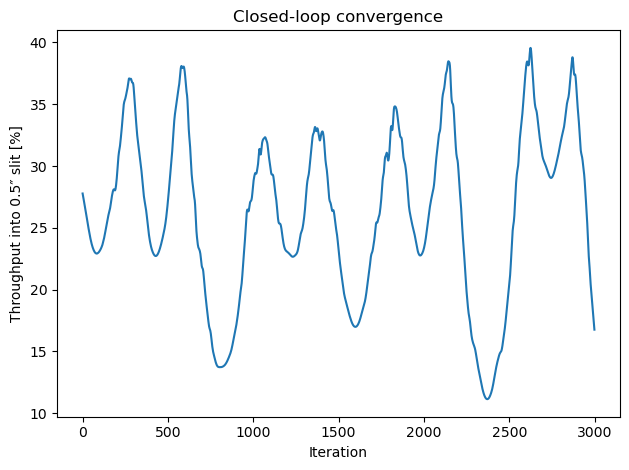

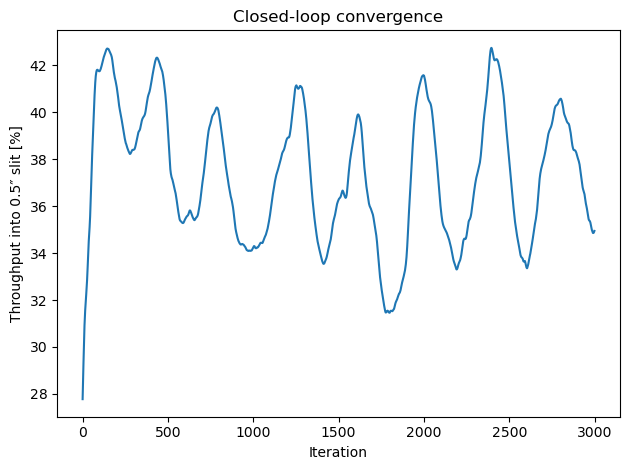

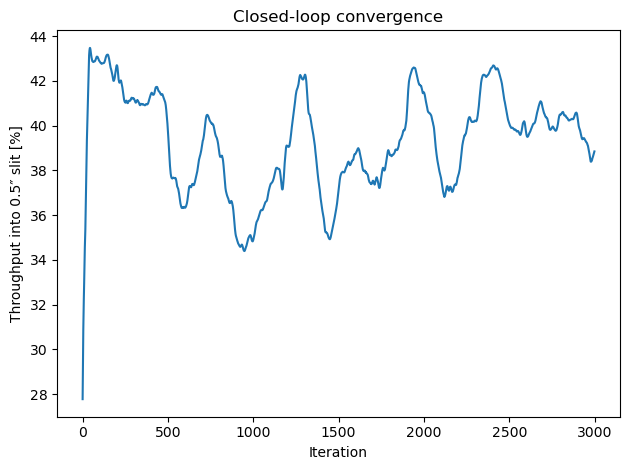

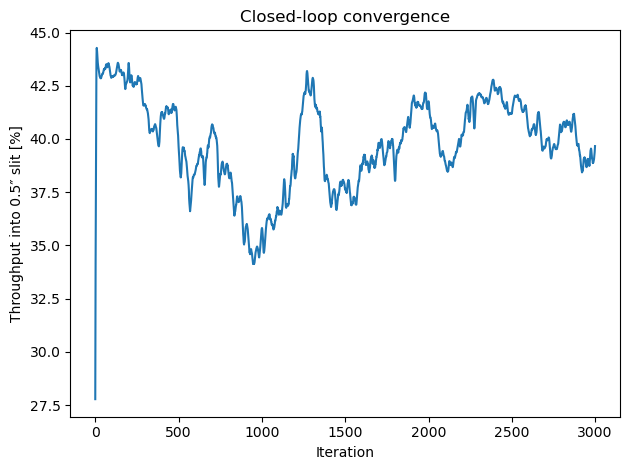

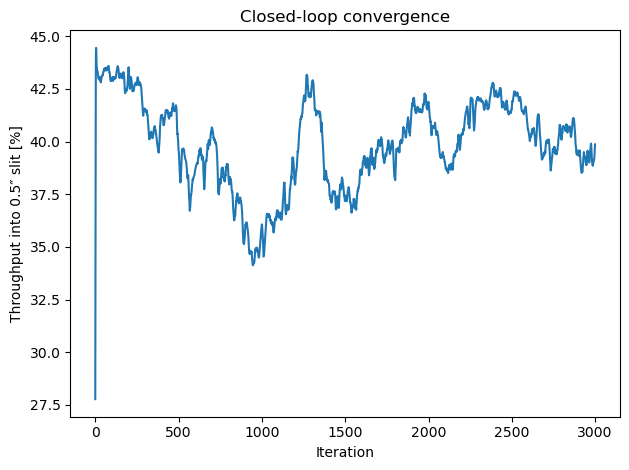

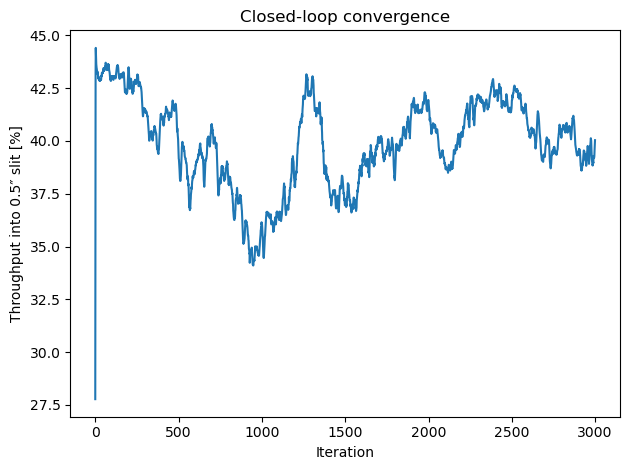

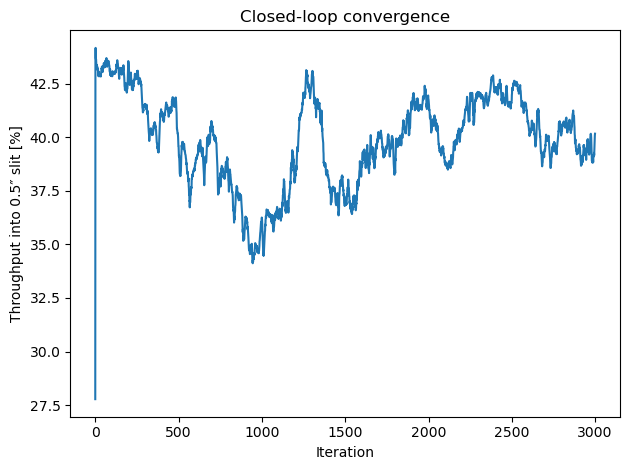

In [ ]:
##### DO NOT TOUCH UNLESS NECESSARY #####

raise Exception("ARE YOU SURE YOU WANT TO RUN THIS?")

results_by_gain = {}

# Loop through desired num_modes values
for gain in [0,0.03,0.07,0.3,0.5,0.7,1.0]:
    print(f"\nRunning simulation with gain = {gain}")
    throughput_vec = run_simulation(
        create_atmosphere(),
        wavelength_sci,
        zb,
        gain=gain,
        num_iterations=3000,
        burn_in_iterations=0,
        slit_mask=slit_mask,
        leakage=0,
        # animate=True,
        **shared_optics
    )
    # Save the result
    results_by_gain[f"gain_value_{gain}"] = throughput_vec
    # display(anim) #uncomment if animate=True


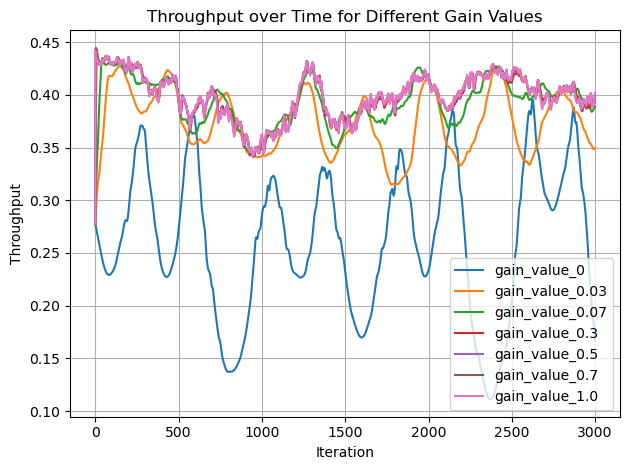

{'gain_value_0': 0.2596420790099776,
 'gain_value_0.03': 0.36851847510790464,
 'gain_value_0.07': 0.38893348481938034,
 'gain_value_0.3': 0.3939560786351555,
 'gain_value_0.5': 0.39423644959203263,
 'gain_value_0.7': 0.39438583838431407,
 'gain_value_1.0': 0.39441822797512494}

In [98]:
results_by_gain

for key, val in results_by_gain.items():
    plt.plot(val, label=key)

plt.xlabel("Iteration")
plt.ylabel("Throughput")
plt.title("Throughput over Time for Different Gain Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

results_by_gain_mean = {
    f"{key}": np.mean(val[500:])
    for key, val in results_by_gain.items()
}

results_by_gain_mean

# vs num_modes


Running simulation with num_modes = 3
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 3/3
[############################################################] 3000/3000

Running simulation with num_modes = 5
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 5/5
[############################################################] 3000/3000

Running simulation with num_modes = 10
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 10/10
[############################################################] 3000/3000

Running simulation with num_modes = 15
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 15/15
[############################################################] 3000/3000

Running simulation with num_modes = 20
r0   = 6.7cm
L0   = 40

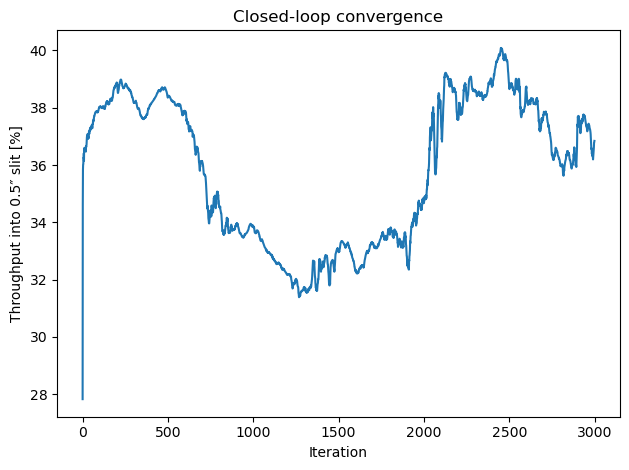

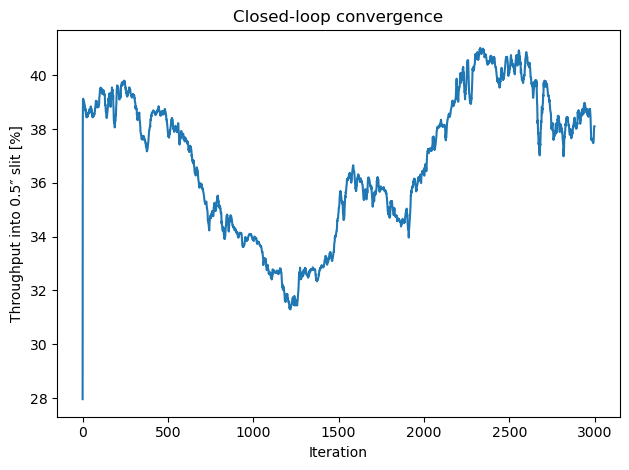

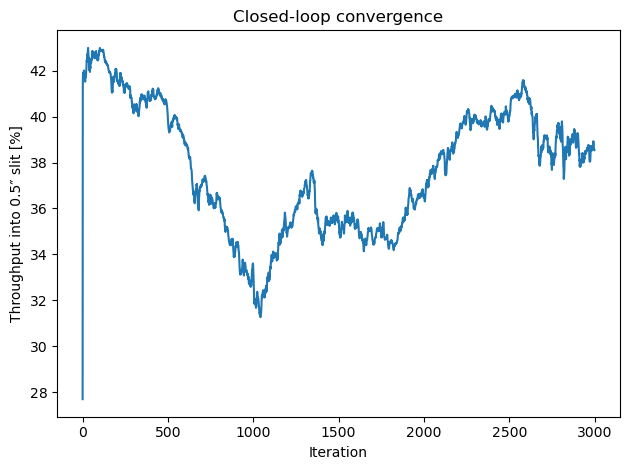

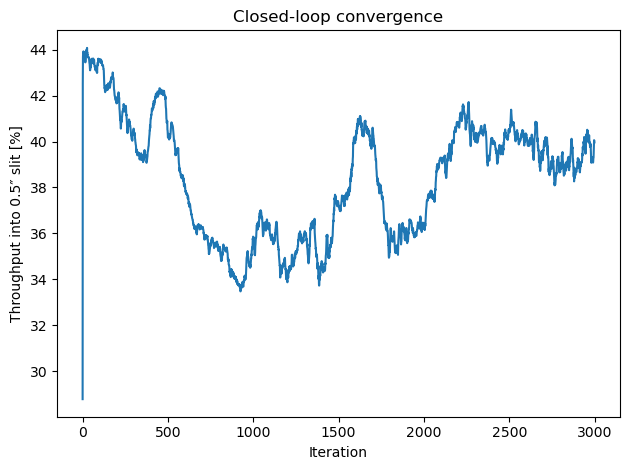

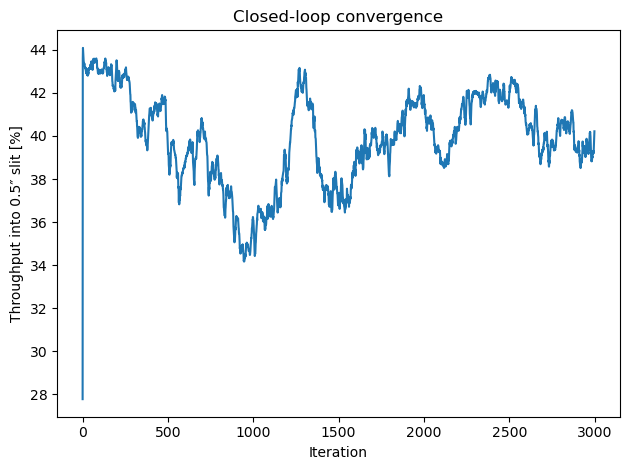

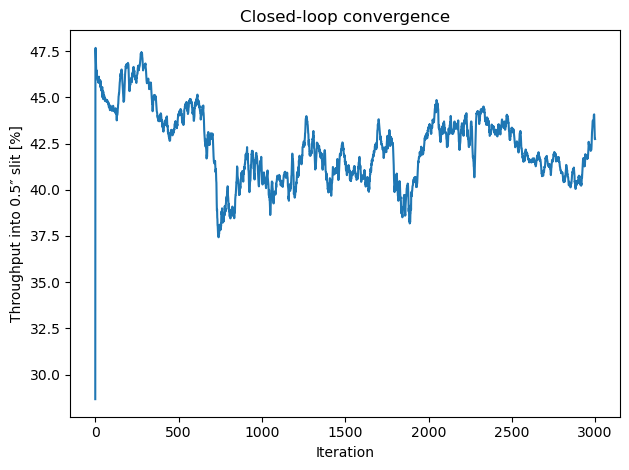

In [ ]:
##### DO NOT TOUCH UNLESS NECESSARY #####

raise Exception("ARE YOU SURE YOU WANT TO RUN THIS?")

results_by_num_modes = {}

# Loop through desired num_modes values
for modes in [3,5,10,15,20,30]:
    print(f"\nRunning simulation with num_modes = {modes}")
    throughput_vec = run_simulation(
        create_atmosphere(),
        wavelength_sci,
        zb,
        num_modes=modes,
        num_iterations=3000,
        burn_in_iterations=0,
        slit_mask=slit_mask,
        **shared_optics
    )
    # Save the result
    results_by_num_modes[f"num_modes_{modes}"] = throughput_vec



Running simulation with num_modes = 100
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 100/100
[############################################################] 3000/3000

Running simulation with num_modes = 150
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 150/150
[############################################################] 3000/3000

Running simulation with num_modes = 200
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 200/200
[############################################################] 3000/3000


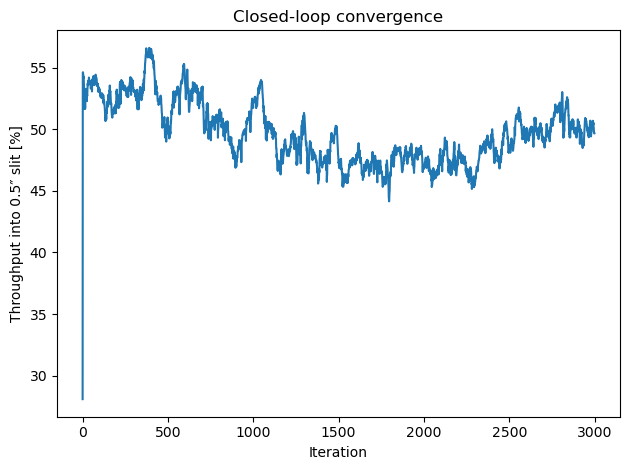

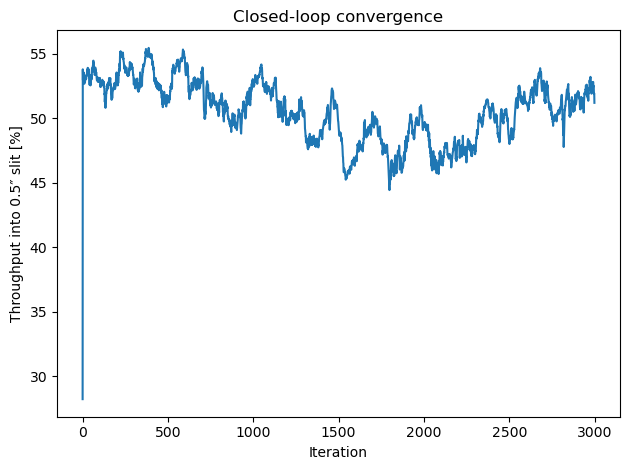

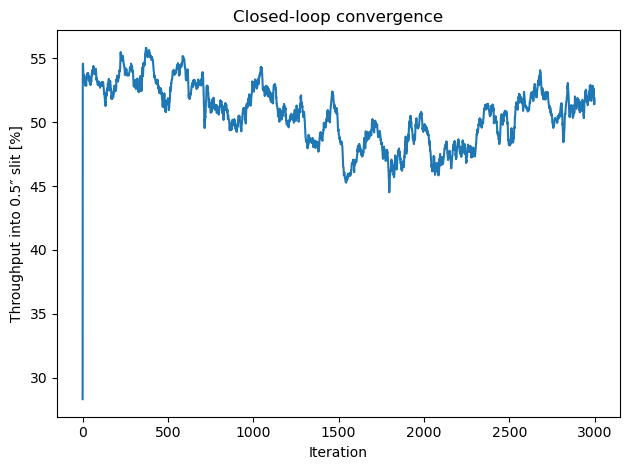

In [61]:
for modes in [100,150,200]:
    print(f"\nRunning simulation with num_modes = {modes}")
    throughput_vec = run_simulation(
        create_atmosphere(),
        wavelength_sci,
        zb,
        num_modes=modes,
        num_iterations=3000,
        burn_in_iterations=0,
        slit_mask=slit_mask,
        **shared_optics
    )
    # Save the result
    results_by_num_modes[f"num_modes_{modes}"] = throughput_vec


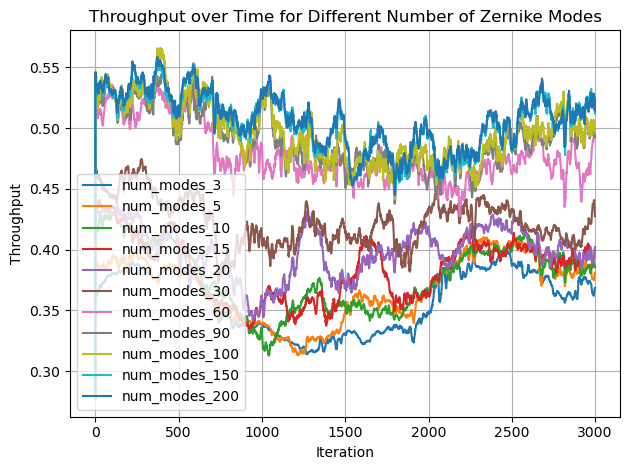

In [62]:
results_by_num_modes

for key, val in results_by_num_modes.items():
    plt.plot(val, label=key)

plt.xlabel("Iteration")
plt.ylabel("Throughput")
plt.title("Throughput over Time for Different Number of Zernike Modes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## push it up to 60, 90, and see what's the graph look like. then, redo the gain calculation w/ optimal no. of modes to see if anything changes

In [65]:
results_by_num_modes_mean = {
    f"{key}": np.mean(val[500:])
    for key, val in results_by_num_modes.items()
}

results_by_num_modes_mean

{'num_modes_3': 0.3539070985356556,
 'num_modes_5': 0.36447231115388457,
 'num_modes_10': 0.37004337495137846,
 'num_modes_15': 0.37730001693396564,
 'num_modes_20': 0.3945064951385113,
 'num_modes_30': 0.41796319458648806,
 'num_modes_60': 0.4710290741244236,
 'num_modes_90': 0.4852393864072748,
 'num_modes_100': 0.49033422254668896,
 'num_modes_150': 0.5004488485351725,
 'num_modes_200': 0.5012848930431895}

# vs Triangle Layout


Running simulation with num_modes = 3
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 3/3
[############################################################] 1000/1000

Running simulation with num_modes = 5
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 5/5
[############################################################] 1000/1000

Running simulation with num_modes = 10
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 10/10
[############################################################] 1000/1000

Running simulation with num_modes = 15
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 15/15
[############################################################] 1000/1000

Running simulation with num_modes = 20
r0   = 6.7cm
L0   = 40

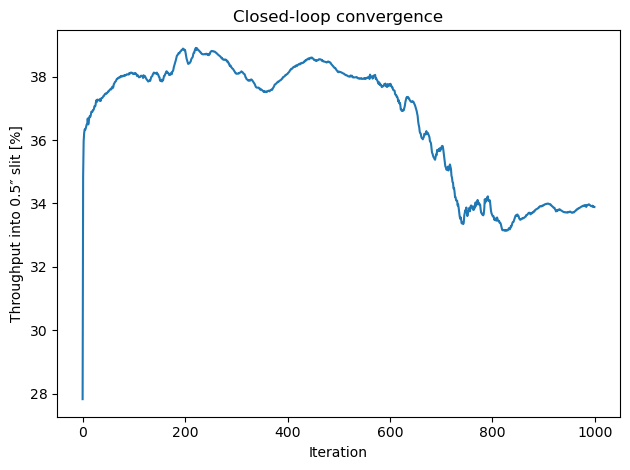

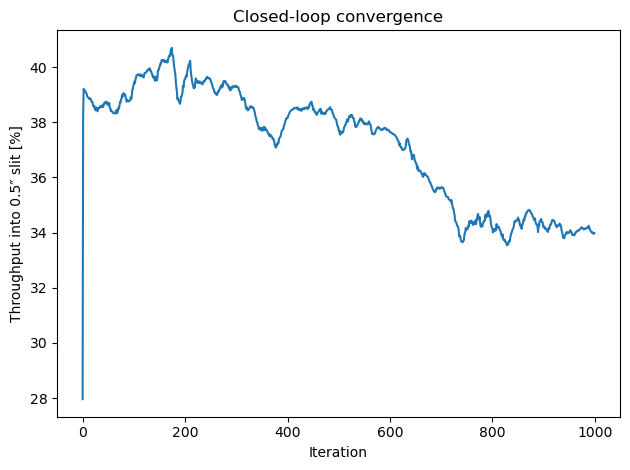

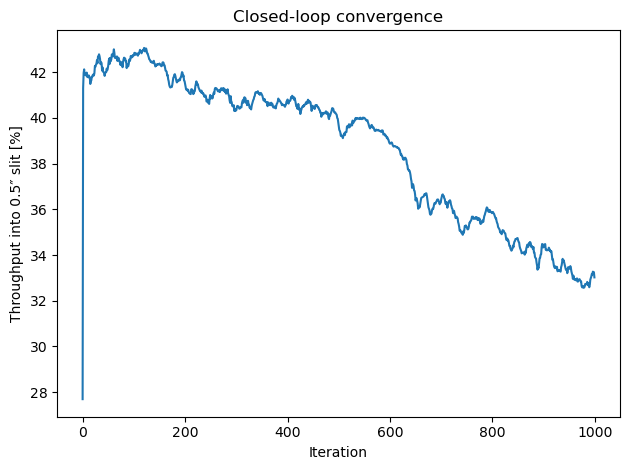

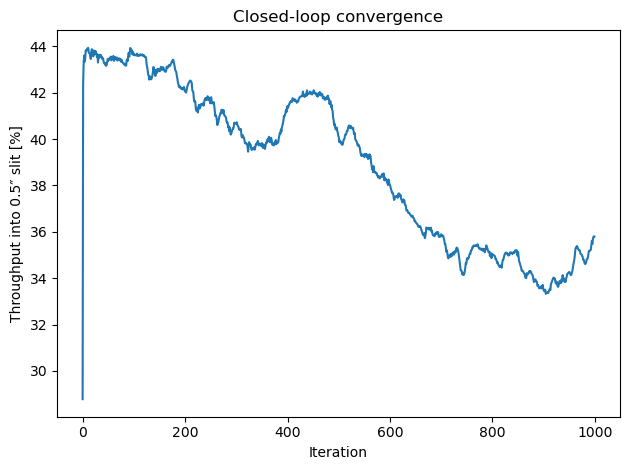

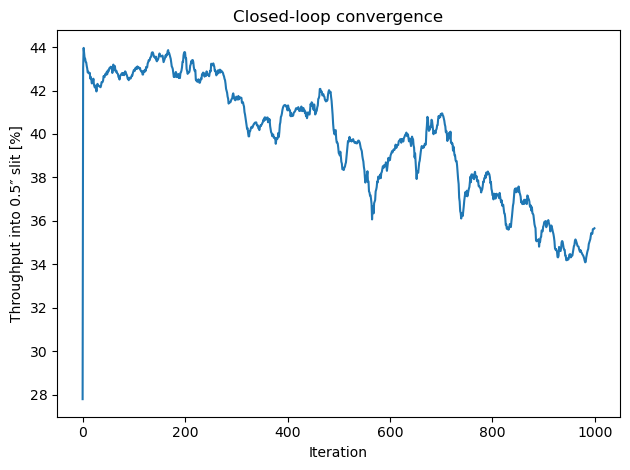

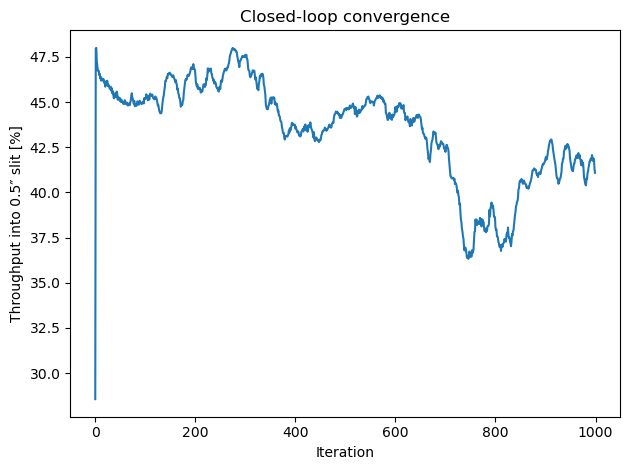

In [37]:
results_by_num_modes_triangle = {}

# Loop through desired num_modes values
for modes in [3,5,10,15,20,30]:
    print(f"\nRunning simulation with num_modes = {modes}")
    throughput_vec = run_simulation(
        create_atmosphere(),
        wavelength_sci,
        zb,
        num_modes=modes,
        num_iterations=1000,
        burn_in_iterations=0,
        slit_mask=slit_mask,
        **shared_optics
    )
    # Save the result
    results_by_num_modes_triangle[f"num_modes_{modes}"] = throughput_vec

In [ ]:
results_by_num_modes_triangle_mean = {
    f"{key}": np.mean(val[500:])
    for key, val in results_by_num_modes_triangle.items()
}

results_by_num_modes_triangle_mean

# results_by_num_modes_mean = #results using the circular DM
{'num_modes_3': 0.3539070985356556,
 'num_modes_5': 0.36447231115388457,
 'num_modes_10': 0.37004337495137846,
 'num_modes_15': 0.37730001693396564,
 'num_modes_20': 0.3945064951385113,
 'num_modes_30': 0.41796319458648806}

{'num_modes_3': 0.3523524484189145,
 'num_modes_5': 0.35467460704923504,
 'num_modes_10': 0.360827947053974,
 'num_modes_15': 0.3598466495234527,
 'num_modes_20': 0.37590906308669536,
 'num_modes_30': 0.4165504198883325}

# vs # of Actuators

/opt/homebrew/anaconda3/envs/hcipy_env/lib/python3.10/site-packages/hcipy/field/grid.py:107: UserWarning: No automatic weights could be calculated for this grid.
  if np.isscalar(self.weights):


61

Running simulation with no. of actuators = 61
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 20/20
[############################################################] 20/20


/opt/homebrew/anaconda3/envs/hcipy_env/lib/python3.10/site-packages/hcipy/field/grid.py:107: UserWarning: No automatic weights could be calculated for this grid.
  if np.isscalar(self.weights):


91

Running simulation with no. of actuators = 91
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 20/20
[############################################################] 20/20


/opt/homebrew/anaconda3/envs/hcipy_env/lib/python3.10/site-packages/hcipy/field/grid.py:107: UserWarning: No automatic weights could be calculated for this grid.
  if np.isscalar(self.weights):


127

Running simulation with no. of actuators = 127
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 20/20
[############################################################] 20/20


/opt/homebrew/anaconda3/envs/hcipy_env/lib/python3.10/site-packages/hcipy/field/grid.py:107: UserWarning: No automatic weights could be calculated for this grid.
  if np.isscalar(self.weights):


169

Running simulation with no. of actuators = 169
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s


LinAlgError: Singular matrix

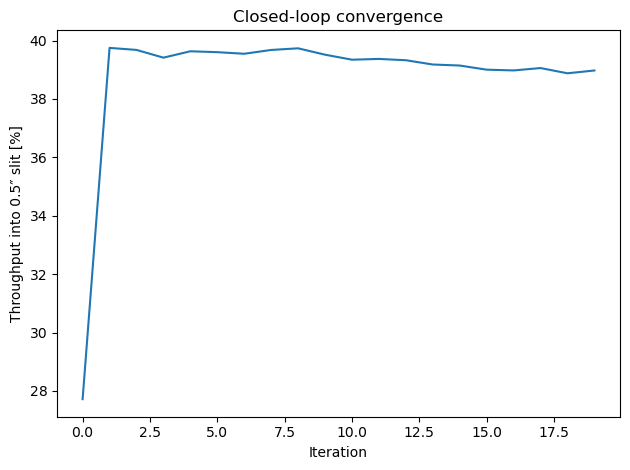

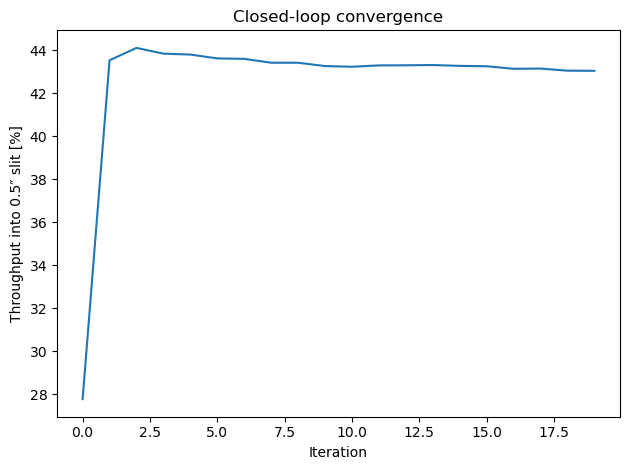

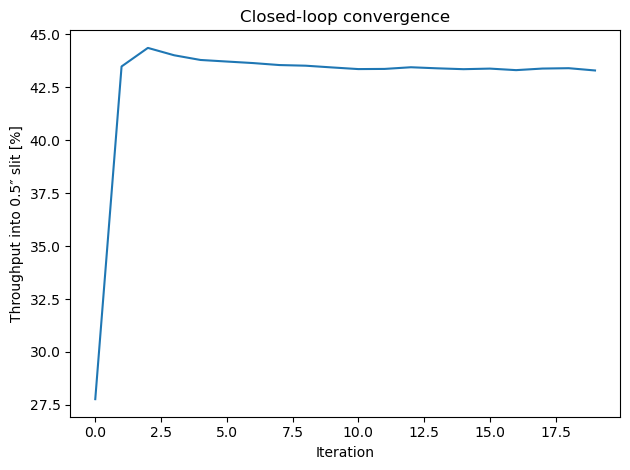

In [99]:


# influence_functions = make_gaussian_influence_functions(pupil_grid, triangle_layout=True,
                                                        # circular_layout=False, num_rings=5,
                                                        # points_first_ring=6, crosstalk=0.3,
                                                        # actuator_spacing=0.3)


results_by_circ_actuator={}

for num_rings in [4,5,6,7]:
    influence_functions = make_gaussian_influence_functions(pupil_grid, num_rings=num_rings, circular_layout=True, crosstalk=0.3, points_first_ring=6, actuator_spacing=0.3)
    deformable_mirror = SamDeformableMirror(influence_functions)
    print (len(deformable_mirror.actuators))
    print(f"\nRunning simulation with no. of actuators = {len(deformable_mirror.actuators)}")
    shared_optics = {
    "deformable_mirror": deformable_mirror,
    "shwfs": shwfs,
    "shwfse": shwfse,
    "camera": camera,
    "magnifier": magnifier,
    "wf": wf,
    "aperture": aperture,
    "pupil_grid": pupil_grid,
    "wavelength_wfs": wavelength_wfs,
    "pupil_grid_diameter": pupil_grid_diameter
    }
    throughput_vec = run_simulation(
        create_atmosphere(),
        wavelength_sci,
        zb,
        num_iterations=20,
        burn_in_iterations=0,
        slit_mask=slit_mask,
        **shared_optics
    )
    # Save the result
    results_by_circ_actuator[f"num_act_{len(deformable_mirror.actuators)}"] = throughput_vec

In [ ]:
results_by_circ_actuator_mean = {
    f"{key}": np.mean(val[500:])
    for key, val in results_by_circ_actuator.items()
}

results_by_circ_actuator_mean


{'num_act_91': 0.3778656888593648}

# No. of subapertures


Running simulation with no. of subapertures across = 17
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 90/90


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/homebrew/anaconda3/envs/hcipy_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16

[############################################################] 100/100


Input #0, image2pipe, from 'fd:':
  Duration: N/A, bitrate: N/A
  Stream #0:0: Video: png, rgba(pc, gbr/unknown/unknown), 800x800 [SAR 3937:3937 DAR 1:1], 10 fps, 10 tbr, 10 tbn
[out#0/mp4 @ 0x139704590] Codec AVOption crf (Select the quality for constant quality mode) has not been used for any stream. The most likely reason is either wrong type (e.g. a video option with no video streams) or that it is a private option of some encoder which was not actually used for any stream.
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libopenh264))
[libopenh264 @ 0x139713a50] [OpenH264] this = 0x0x13a00c530, Warning:layerId(0) doesn't support profile(578), change to UNSPECIFIC profile
[libopenh264 @ 0x139713a50] [OpenH264] this = 0x0x13a00c530, Warning:bEnableFrameSkip = 0,bitrate can't be controlled for RC_QUALITY_MODE,RC_BITRATE_MODE and RC_TIMESTAMP_MODE without enabling skip frame.
[libopenh264 @ 0x139713a50] [OpenH264] this = 0x0x13a00c530, Warning:Change QP Range from(0,51) to

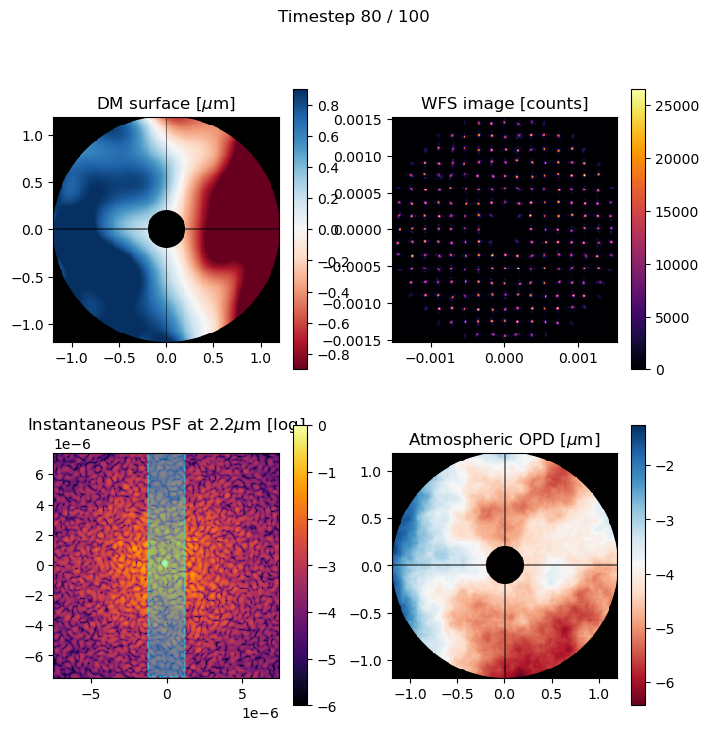

In [203]:
testing= {}
num_subap_across = 17
shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number, \
                                                 num_subap_across, sh_diameter)
shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)
print(f"\nRunning simulation with no. of subapertures across = {num_subap_across}")
shared_optics = {
"deformable_mirror": deformable_mirror,
"shwfs": shwfs,
"shwfse": shwfse,
"camera": camera,
"magnifier": magnifier,
"wf": wf,
"aperture": aperture,
"pupil_grid": pupil_grid,
"wavelength_wfs": wavelength_wfs,
"pupil_grid_diameter": pupil_grid_diameter
}
throughput_vec, anim = run_simulation(
    create_atmosphere(),
    wavelength_sci,
    zb,
    num_iterations=100,
    burn_in_iterations=0,
    slit_mask=slit_mask,
    animate=True,
    **shared_optics
)
testing[f"num_subap_{num_subap_across}x{num_subap_across}={num_subap_across}"] = throughput_vec
anim

In [204]:
telescope_diameter = 2.4 # meter
central_obscuration = 0.4 # meter
central_obscuration_ratio = central_obscuration / telescope_diameter
spider_width = 0.01 # meter

# oversizing_factor = 16 / 15
num_pupil_pixels = 240
pupil_grid_diameter = telescope_diameter #* oversizing_factor
#why oversize? prevent aliasing, think of it as "padding" the edges
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

aperture_generator = make_obstructed_circular_aperture(telescope_diameter,
    central_obscuration_ratio, num_spiders=4, spider_width=spider_width)

aperture = evaluate_supersampled(aperture_generator, pupil_grid, 4)
# renders the aperture at 4x resolution before downsampling to prevent aliasing


wavelength_wfs = 0.632e-6
wavelength_sci = 0.6e-6 # scientific camera wavelength
#PMH - changed to NIR (2.2 um) for demo purposes.
# wavelength_sci = 2.2e-6 # scientific camera wavelength

wf = Wavefront(aperture, wavelength_sci)
wf.total_power = 1

# scientific camera
spatial_resolution = wavelength_sci / telescope_diameter #arcsec
focal_grid = make_focal_grid(q=4, num_airy=30, spatial_resolution=spatial_resolution)
# q=4 means 4 pixels per spatial resolution element (lambda/D)

# --- spectroscopy slit mask (rectangular, 0.5") --------------------------
arcsec2rad   = np.pi / (180.0 * 3600.0)
slit_width   = 0.5 * arcsec2rad        # 0.5 arcsec → rad
slit_mask    = (np.abs(focal_grid.x) <= slit_width/2)   # slit is tall, narrow in x


# -----------------------------

# storage for diagnostics

propagator = FraunhoferPropagator(pupil_grid, focal_grid)

f_number = 5.2/.146 #focal length/lenslet lens size using Thorlabs MLA150-5C-M - Ø1" Mounted Lens Array
f_number = 50 # PMH- guess. Alpao doesn't provide documentation.

num_lenslets = 15 # 15 lenslets along one diameter
sh_diameter = 16* 1.92E-4   #PMH - Alpao EMCCD has 192 um lenslets
print (sh_diameter)
magnification = sh_diameter / telescope_diameter
magnifier = Magnifier(magnification)

shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number, \
                                                 num_lenslets, sh_diameter)
shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)



camera = NoiselessDetector(focal_grid)
wf = Wavefront(aperture, wavelength_wfs)
camera.integrate(shwfs(magnifier(wf)), 1)

from SamDeformableMirror import make_gaussian_influence_functions, SamDeformableMirror

influence_functions = make_gaussian_influence_functions(pupil_grid, num_rings=5,
                                                        crosstalk=0.3,
                                                        points_first_ring=6, actuator_spacing=0.3)

# influence_functions = make_gaussian_influence_functions(pupil_grid, triangle_layout=True,
                                                        # circular_layout=False, num_rings=5,
                                                        # points_first_ring=6, crosstalk=0.3,
                                                        # actuator_spacing=0.3)


deformable_mirror = SamDeformableMirror(influence_functions)
shared_optics = {
    "deformable_mirror": deformable_mirror,
    "shwfs": shwfs,
    "shwfse": shwfse,
    "camera": camera,
    "magnifier": magnifier,
    "wf": wf,
    "aperture": aperture,
    "pupil_grid": pupil_grid,
    "wavelength_wfs": wavelength_wfs,
    "pupil_grid_diameter": pupil_grid_diameter
}
Mode2Act, reconstruction_matrix, anim = compute_Mode2Act_and_reconstruction_matrix(20, animate=True, **shared_optics)
anim

0.003072


/opt/homebrew/anaconda3/envs/hcipy_env/lib/python3.10/site-packages/hcipy/field/grid.py:107: UserWarning: No automatic weights could be calculated for this grid.
  if np.isscalar(self.weights):


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/homebrew/anaconda3/envs/hcipy_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16

[############################################################] 20/20


Input #0, image2pipe, from 'fd:':
  Duration: N/A, bitrate: N/A
  Stream #0:0: Video: png, rgba(pc, gbr/unknown/unknown), 1000x600 [SAR 3937:3937 DAR 5:3], 5 fps, 5 tbr, 5 tbn
[out#0/mp4 @ 0x13be05b70] Codec AVOption crf (Select the quality for constant quality mode) has not been used for any stream. The most likely reason is either wrong type (e.g. a video option with no video streams) or that it is a private option of some encoder which was not actually used for any stream.
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libopenh264))
[libopenh264 @ 0x13be067c0] [OpenH264] this = 0x0x13c810700, Warning:layerId(0) doesn't support profile(578), change to UNSPECIFIC profile
[libopenh264 @ 0x13be067c0] [OpenH264] this = 0x0x13c810700, Warning:bEnableFrameSkip = 0,bitrate can't be controlled for RC_QUALITY_MODE,RC_BITRATE_MODE and RC_TIMESTAMP_MODE without enabling skip frame.
[libopenh264 @ 0x13be067c0] [OpenH264] this = 0x0x13c810700, Warning:Change QP Range from(0,51) to (

r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 35/35


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/homebrew/anaconda3/envs/hcipy_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16

[############################################################] 100/100


Input #0, image2pipe, from 'fd:':
  Duration: N/A, bitrate: N/A
  Stream #0:0: Video: png, rgba(pc, gbr/unknown/unknown), 800x800 [SAR 3937:3937 DAR 1:1], 10 fps, 10 tbr, 10 tbn
[out#0/mp4 @ 0x113604710] Codec AVOption crf (Select the quality for constant quality mode) has not been used for any stream. The most likely reason is either wrong type (e.g. a video option with no video streams) or that it is a private option of some encoder which was not actually used for any stream.
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libopenh264))
[libopenh264 @ 0x113704c40] [OpenH264] this = 0x0x115004c40, Warning:layerId(0) doesn't support profile(578), change to UNSPECIFIC profile
[libopenh264 @ 0x113704c40] [OpenH264] this = 0x0x115004c40, Warning:bEnableFrameSkip = 0,bitrate can't be controlled for RC_QUALITY_MODE,RC_BITRATE_MODE and RC_TIMESTAMP_MODE without enabling skip frame.
[libopenh264 @ 0x113704c40] [OpenH264] this = 0x0x115004c40, Warning:Change QP Range from(0,51) to

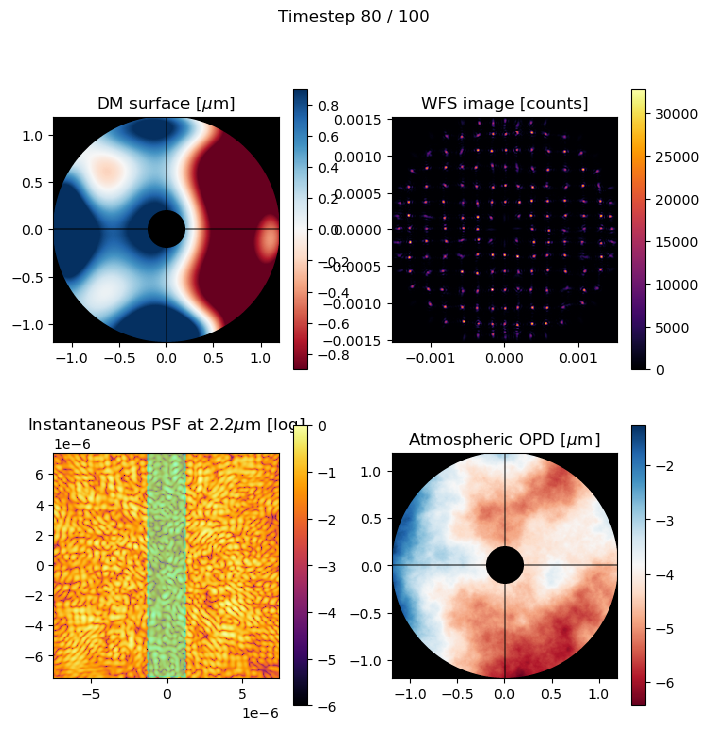

In [205]:
num_subap_across = 4

# pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
# zb = make_zernike_basis(10, pupil_grid_diameter, pupil_grid) 


# aperture_generator = make_obstructed_circular_aperture(telescope_diameter, central_obscuration_ratio, num_spiders=4, spider_width=spider_width)

# aperture = evaluate_supersampled(aperture_generator, pupil_grid, 4)
# magnifier = Magnifier(magnification)
# focal_grid = make_focal_grid(q=4, num_airy=30, spatial_resolution=spatial_resolution)
# propagator = FraunhoferPropagator(pupil_grid, focal_grid)
# influence_functions = make_gaussian_influence_functions(pupil_grid, num_rings=5,
#                                                         crosstalk=0.3,
#                                                         points_first_ring=6, actuator_spacing=0.3)

# wf = Wavefront(aperture, wavelength_wfs)
# wf.total_power = 1  # Important to normalize after recreation
# deformable_mirror = SamDeformableMirror(influence_functions)

# shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number, \
#                                                  num_subap_across, sh_diameter)
# shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)
# print(f"\nRunning simulation with no. of subapertures across = {num_subap_across}")



# shared_optics = {
# "deformable_mirror": deformable_mirror,
# "shwfs": shwfs,
# "shwfse": shwfse,
# "camera": camera,
# "magnifier": magnifier,
# "wf": wf,
# "aperture": aperture,
# "pupil_grid": pupil_grid,
# "wavelength_wfs": wavelength_wfs,
# "pupil_grid_diameter": pupil_grid_diameter
# }
throughput_vec, anim = run_simulation(
    create_atmosphere(),
    wavelength_sci,
    zb,
    num_modes=35,
    num_iterations=100,
    burn_in_iterations=0,
    slit_mask=slit_mask,
    animate=True,
    **shared_optics
)
testing[f"num_subap_{num_subap_across}x{num_subap_across}={num_subap_across}"] = throughput_vec
anim

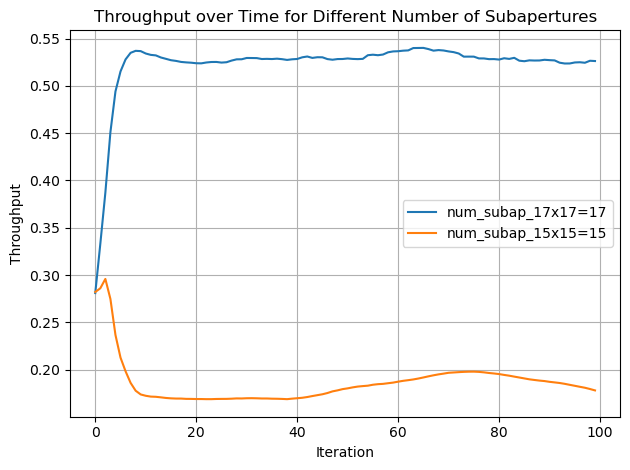

In [164]:


for key, val in testing.items():
    plt.plot(val, label=key)

plt.xlabel("Iteration")
plt.ylabel("Throughput")
plt.title("Throughput over Time for Different Number of Subapertures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [162]:
for num_subap_across in []:
    aperture = evaluate_supersampled(aperture_generator, pupil_grid, 4)
    shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number, \
                                                    num_subap_across, sh_diameter)
    shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)
    print(f"\nRunning simulation with no. of subapertures across = {num_subap_across}")

    shared_optics = {
    "deformable_mirror": deformable_mirror,
    "shwfs": shwfs,
    "shwfse": shwfse,
    "camera": camera,
    "magnifier": magnifier,
    "wf": wf,
    "aperture": aperture,
    "pupil_grid": pupil_grid,
    "wavelength_wfs": wavelength_wfs,
    "pupil_grid_diameter": pupil_grid_diameter
    }
    throughput_vec, anim = run_simulation(
        create_atmosphere(),
        wavelength_sci,
        zb,
        num_modes=50,
        num_iterations=100,
        burn_in_iterations=0,
        slit_mask=slit_mask,
        animate=True,
        **shared_optics
    )
    testing[f"num_subap_{num_subap_across}x{num_subap_across}={num_subap_across}"] = throughput_vec
    anim

91

Running simulation with no. of subapertures across = 15
r0   = 6.7cm
L0   = 40.0m
tau0 = 15.0ms
v    = 1.4m/s
[############################################################] 90/90
[############################################################] 100/100


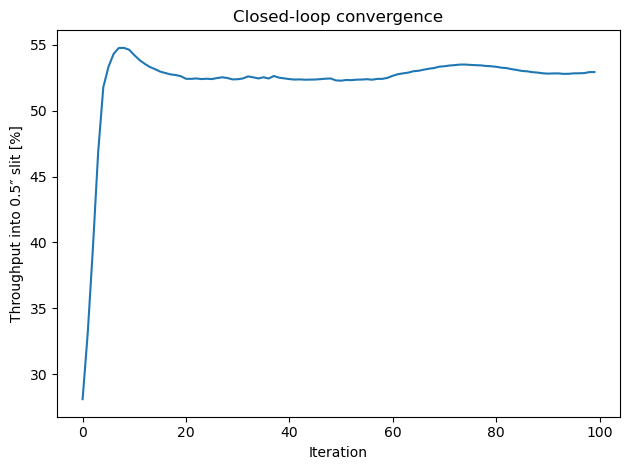

In [134]:
# results_by_subapertures={}
print (len(deformable_mirror.actuators))


# num_lenslets = 15 # 15 lenslets along one diameter
# sh_diameter = 16* 1.92E-4   #PMH - Alpao EMCCD has 192 um lenslets
# print (sh_diameter)
# magnification = sh_diameter / telescope_diameter
# magnifier = Magnifier(magnification)

# shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number, \
#                                                  num_lenslets, sh_diameter)
# shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)



for num_subap_across in [15]: #4,8,12,15,20,25
    aperture = evaluate_supersampled(aperture_generator, pupil_grid, 4)

    shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number, \
                                                 num_subap_across, sh_diameter)
    shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)
    print(f"\nRunning simulation with no. of subapertures across = {num_subap_across}")
    shared_optics = {
    "deformable_mirror": deformable_mirror,
    "shwfs": shwfs,
    "shwfse": shwfse,
    "camera": camera,
    "magnifier": magnifier,
    "wf": wf,
    "aperture": aperture,
    "pupil_grid": pupil_grid,
    "wavelength_wfs": wavelength_wfs,
    "pupil_grid_diameter": pupil_grid_diameter
    }
    throughput_vec = run_simulation(
        create_atmosphere(),
        wavelength_sci,
        zb,
        num_iterations=100,
        burn_in_iterations=0,
        slit_mask=slit_mask,
        **shared_optics
    )
    # Save the result
    results_by_subapertures[f"num_subap_{num_subap_across}x{num_subap_across}={num_subap_across}"] = throughput_vec

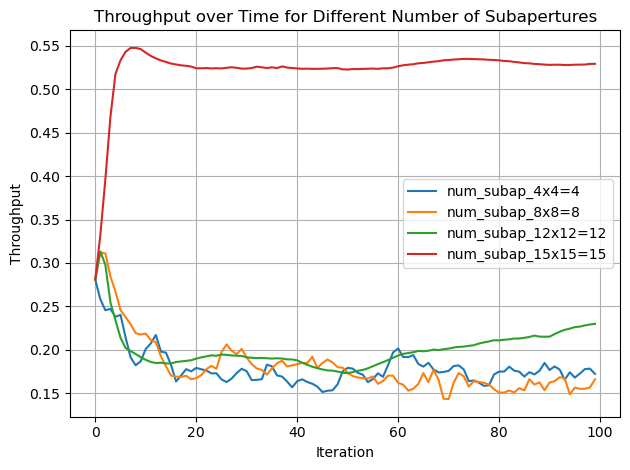

In [135]:
results_by_subapertures

for key, val in results_by_subapertures.items():
    plt.plot(val, label=key)

plt.xlabel("Iteration")
plt.ylabel("Throughput")
plt.title("Throughput over Time for Different Number of Subapertures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

try 180 actuators (listed in the proposal, within TNO's manufacturing capabilities)
